In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, roc_auc_score, classification_report, plot_roc_curve
from imblearn.over_sampling import SMOTE
from sklearn import tree
import graphviz
import pydot
import io
from sklearn.tree import export_graphviz

In [2]:
#load data
data=pd.read_csv("mortgage_final_data.csv")

In [3]:
data.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,gdp_dif,gdp_inc,uer_orig,uer_avg,uer_dif,uer_inc,hpi_avg,hpi_dif,hpi_inc,status_time
0,1,48,-7,25,113,29087.21,26.658065,9.200,146.45,2.715903,...,-0.183234,-0.063203,4.7,7.241667,3.6,0.765957,176.657917,59.42,0.682753,1
1,2,26,18,25,138,105654.77,65.469851,7.680,225.10,2.151365,...,-0.747772,-0.257929,4.7,4.700000,0.0,0.000000,225.695000,38.19,0.204323,2
2,3,29,-6,25,114,44378.60,31.459735,11.375,217.37,1.692969,...,-1.206168,-0.416044,4.7,4.580000,-0.2,-0.042553,222.164000,127.79,1.426546,2
3,5,27,18,25,138,52100.71,66.346343,9.155,222.39,2.361722,...,-0.537415,-0.185371,4.7,4.600000,-0.3,-0.063830,224.593333,35.48,0.189824,2
4,6,56,19,25,139,190474.11,75.834755,6.580,181.43,1.717053,...,-1.182084,-0.407736,4.7,7.319355,1.9,0.404255,175.143226,-9.99,-0.052189,1


In [4]:
#define independent and dependent variables
y=data["status_time"].values
x=data.drop("status_time", axis=1).values

In [5]:
#print number of each class
print("default:", len(data[data["status_time"]==1]))
print("pay off:", len(data[data["status_time"]==2]))

default: 15151
pay off: 26578


In [6]:
#split train and test set
train_x, test_x, train_y, test_y=train_test_split(x, y, train_size=0.8)

In [7]:
#display the number of train set
print("default before SMOTE:", len(train_y[train_y==1]))
print("pay off before SMOTE:", len(train_y[train_y==2]))

default before SMOTE: 12054
pay off before SMOTE: 21329


In [8]:
#use SMOTE to deal with imbalanced data
SMOTE=SMOTE(random_state=0)
S_train_x, S_train_y=SMOTE.fit_sample(train_x, train_y)

In [9]:
#display the number of training set after SMOTE
print("default after SMOTE:", len(S_train_y[S_train_y==1]))
print("pay off after SMOTE:", len(S_train_y[S_train_y==2]))

default after SMOTE: 21329
pay off after SMOTE: 21329


In [10]:
#define model(with all hyperparameter default values)
model=DecisionTreeClassifier()
#train model
model.fit(S_train_x, S_train_y)

DecisionTreeClassifier()

In [11]:
#show the metrics of model fitted(with all hyperparameter default values)
#predict test set
y_pred=model.predict(test_x)
#print classification report
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           1       0.63      0.66      0.64      3097
           2       0.79      0.77      0.78      5249

    accuracy                           0.73      8346
   macro avg       0.71      0.71      0.71      8346
weighted avg       0.73      0.73      0.73      8346



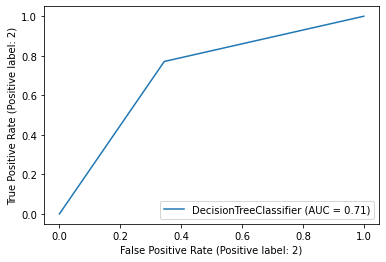

In [12]:
#show roc-auc curve
plot_roc_curve(model, test_x, test_y)

In [13]:
#use grid search to find the best parameter for max_depth
#define a dictionary which identify the paramter that needs to be searched and its possible values
param_grid={"max_depth":np.arange(3, 12)}
#define the grid search model
grid_search=GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring="accuracy")
#fit the grid search model with training set
grid_search.fit(S_train_x, S_train_y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11])},
             scoring='accuracy')

In [14]:
#extract the best value for max_depth
grid_search.best_params_

{'max_depth': 7}

In [15]:
#extract the mean_test_score of model with each possible max_depth
test_scores=grid_search.cv_results_["mean_test_score"]

Text(9, 0.7925, '[9,0.795]')

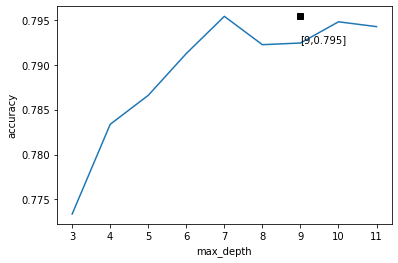

In [16]:
#plot the score with max_depth
plt.plot(np.arange(3, 12), test_scores, label="test_scores")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
#mark the maximum
plt.plot([9], max(test_scores), "ks")
show_max="["+str(9)+","+str(round(max(test_scores),3))+"]"
plt.annotate(show_max,xy=(9, max(test_scores)), xytext=(9,0.7925))

In [17]:
#redefine the model with max_depth=9
model_new=DecisionTreeClassifier(max_depth=9)
#train the new model
model_new.fit(S_train_x, S_train_y)
#get the predicted values for test set
y_pred=model_new.predict(test_x)
#display classification report
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           1       0.69      0.71      0.70      3097
           2       0.83      0.81      0.82      5249

    accuracy                           0.77      8346
   macro avg       0.76      0.76      0.76      8346
weighted avg       0.78      0.77      0.78      8346



In [18]:
#check the accuracy by cross validation
cross_val_score(DecisionTreeClassifier(max_depth=9), S_train_x, S_train_y, cv=5).mean()

0.7922564148303781

In [19]:
#now we check whether our model is overfitting or underfitting
#extract the variables for learning curve
number, train_loss, test_loss=learning_curve(DecisionTreeClassifier(max_depth=9), S_train_x, S_train_y, cv=5, train_sizes=[0.1, 0.33, 0.55, 0.78, 1. ])

Text(0.5, 1.0, 'Learning curve')

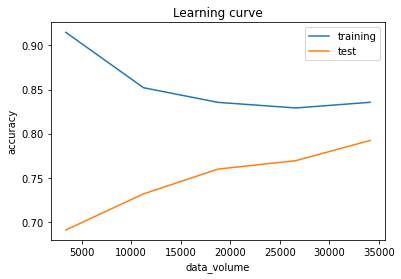

In [20]:
#display learning curve
plt.plot(number, train_loss.mean(axis=1), label=True)
plt.plot(number, test_loss.mean(axis=1), label=True)
plt.legend(["training", "test"])
plt.xlabel("data_volume")
plt.ylabel("accuracy")
plt.title("Learning curve")

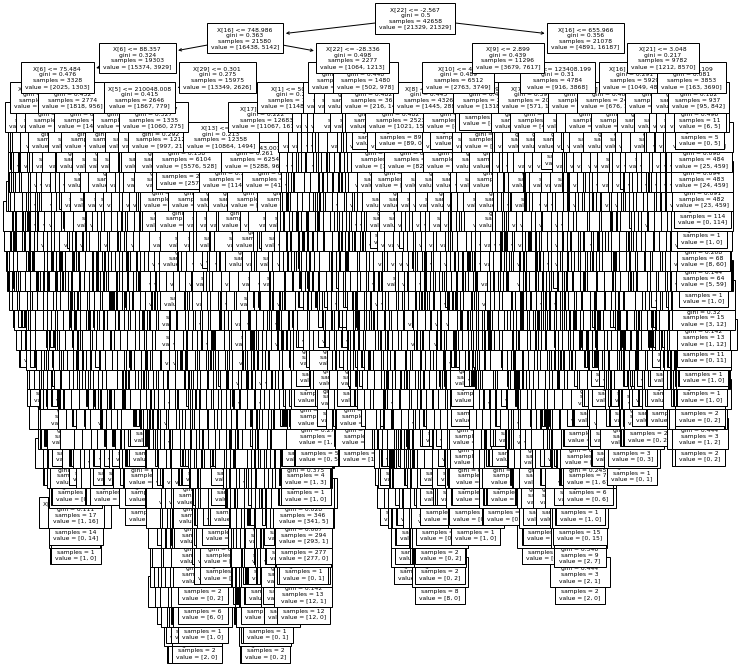

In [21]:
#plot the tree
plt.figure(figsize=(12,12))
tree.plot_tree(model, fontsize=6)
plt.savefig('tree_high_dpi', dpi=100)

In [22]:
#extract the feature importances
importances=model_new.feature_importances_

In [23]:
#generate a list
ls=[(name, importance) for name, importance in zip(data.columns[:-1], importances)]

In [24]:
#sort the list 
ls.sort(key= lambda ls:ls[1], reverse=True)

In [25]:
ls

[('LTV_dif', 0.5569540144939319),
 ('FICO_orig_time', 0.10271983596167278),
 ('LTV_time', 0.048588026746457985),
 ('hpi_time', 0.04083012721988938),
 ('gdp_time', 0.03398257733873684),
 ('uer_time', 0.022345645828436),
 ('time', 0.01795233230501513),
 ('balance_time', 0.017832498163582088),
 ('interest_rate_time', 0.01714537029515491),
 ('REtype_SF_orig_time', 0.013595483667279782),
 ('Interest_Rate_orig_time', 0.013536465395386197),
 ('balance_orig_time', 0.01309774470572506),
 ('LTV_orig_time', 0.011290216425554712),
 ('uer_dif', 0.01124833134574208),
 ('first_time', 0.010269568934763069),
 ('gdp_avg', 0.009379052769315138),
 ('id', 0.008559282667459742),
 ('uer_avg', 0.006524998649310388),
 ('uer_inc', 0.005691213004792399),
 ('uer_orig', 0.0054687611067100505),
 ('mat_time', 0.00424030969486046),
 ('gdp_orig', 0.00419113672276234),
 ('hpi_avg', 0.003911563614486913),
 ('gdp_inc', 0.003768737613345996),
 ('LTV_inc', 0.003660850844240694),
 ('hpi_inc', 0.003498311697225321),
 ('hpi_o